In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

### Data visualisation

In [59]:
#gathering data from the dataset

movies = pd.read_csv('dataset/movies.dat' , sep='::' , engine='python' , encoding='latin-1' , header=None)
movies.columns = ['movie_id' , 'title' , 'genres']

ratings = pd.read_csv('dataset/ratings.dat' , sep='::' , engine='python' , encoding='latin-1' , header=None)
ratings.columns = ['user_id' , 'movie_id' , 'rating' , 'timestamp']

users = pd.read_csv('dataset/users.dat' , sep='::' , engine='python' , encoding='latin-1' , header=None)
users.columns = ['user_id','gender','age','occupation','zip_code']

In [60]:
print(movies.shape , ratings.shape , users.shape)

(3883, 3) (1000209, 4) (6040, 5)


In [61]:
#merging the dataframes movies and ratings on the basis of movie_id aggregate the ratings of each movie
movie_ratings = pd.merge(movies , ratings , on='movie_id')
movie_ratings_mean = movie_ratings.groupby('title').agg({'rating':[np.size,np.mean]})
movie_ratings.head()

,movie_id,title,genres,user_id,rating,timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474


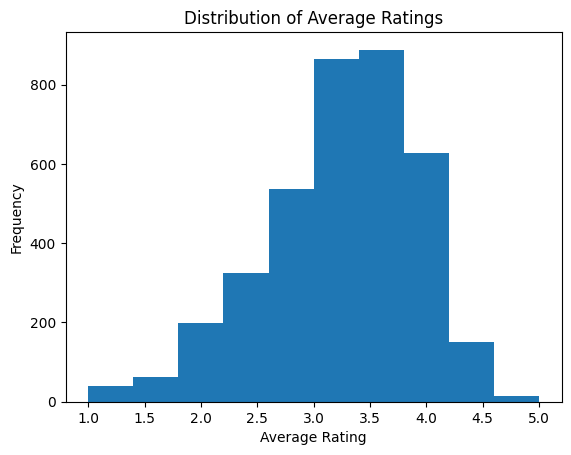

In [62]:
#plot the average rating of each movie
plt.hist(movie_ratings_mean['rating']['mean'])
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Average Ratings')
plt.show()

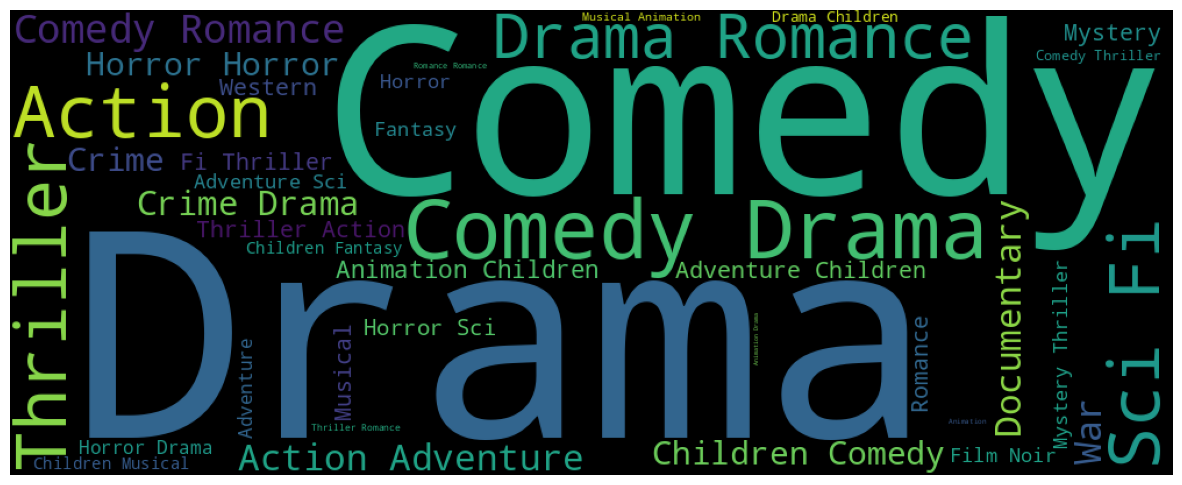

In [63]:
#show the relationship between the average rating and genre
genres = set()
for genre in movies.genres.str.split('|').values:
    genres = genres.union(set(genre))
genres = list(genres)

#display wordcloud of genres
genre_wordcloud = WordCloud(width=1000,height=400).generate(' '.join(movies['genres']))
plt.figure(figsize=(15,10))
plt.imshow(genre_wordcloud)
plt.axis('off')
plt.show()

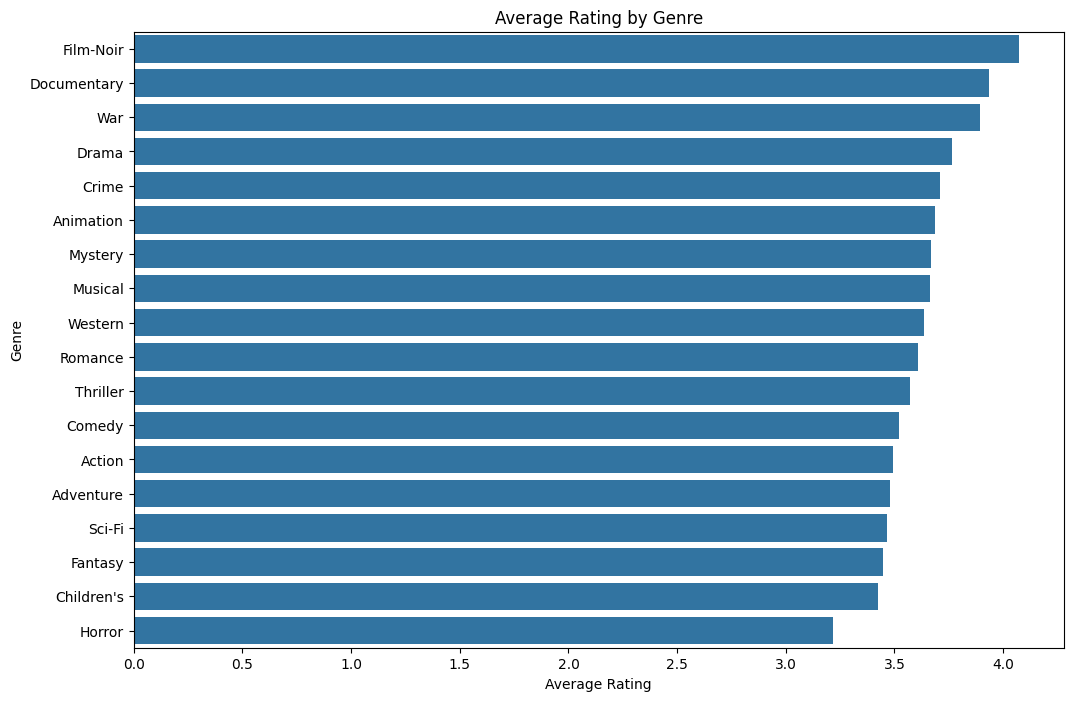

In [64]:
#merge movies and ratings dataframes on the basis of genre and aggregate the ratings of each genre

movies_exploded = movies.copy()
movies_exploded['genre'] = movies_exploded['genres'].str.split('|')
movies_exploded = movies_exploded.explode('genre')

# Step 3: Merge with ratings DataFrame on movieId
merged_data = pd.merge(movies_exploded[['movie_id', 'genre']], ratings[['movie_id', 'rating']], on='movie_id')

# Step 4: Calculate the average rating for each genre
genre_ratings = merged_data.groupby('genre')['rating'].mean().reset_index()
genre_ratings.columns = ['genre', 'average_rating']

genre_ratings_sorted = genre_ratings.sort_values(by='average_rating', ascending=False)

# Display the average rating per genre in a bar chart top to bottom sorted
plt.figure(figsize=(12, 8))
sns.barplot(x='average_rating', y='genre', data=genre_ratings_sorted)
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.title('Average Rating by Genre')
plt.show()


## Data Preprocessing

In [73]:
#use Label encoding to encode the genres
le = LabelEncoder()
le.fit(genres)

# Step 3: Apply label encoding to each genre in 'movies' DataFrame
movies_encoded = movies.copy()
# Encode each genre in the 'genres' column
movies_encoded['genres_encoded'] = movies_encoded['genres'].apply(
    lambda x: le.transform(x.split('|')).tolist()  # Split, encode, and store as a list
)


#convert timestamp to datetime
movies_encoded['timestamp'] = pd.to_datetime(movie_ratings['timestamp'], unit='s')


movies_encoded.head(10)

,movie_id,title,genres,genres_encoded,timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,"[2, 3, 4]",2001-01-06 23:37:48
1,2,Jumanji (1995),Adventure|Children's|Fantasy,"[1, 3, 8]",2000-12-31 04:30:08
2,3,Grumpier Old Men (1995),Comedy|Romance,"[4, 13]",2000-12-31 03:31:36
3,4,Waiting to Exhale (1995),Comedy|Drama,"[4, 7]",2000-12-31 01:25:52
4,5,Father of the Bride Part II (1995),Comedy,[4],2000-12-31 01:34:34
5,6,Heat (1995),Action|Crime|Thriller,"[0, 5, 15]",2000-12-30 05:39:28
6,7,Sabrina (1995),Comedy|Romance,"[4, 13]",2001-01-03 21:06:34
7,8,Tom and Huck (1995),Adventure|Children's,"[1, 3]",2000-12-30 01:22:27
8,9,Sudden Death (1995),Action,[0],2001-01-02 19:26:54
9,10,GoldenEye (1995),Action|Adventure|Thriller,"[0, 1, 15]",2000-12-29 22:58:23


In [66]:
#User-Item Matrix

user_movie_matrix = movie_ratings.pivot_table(index='user_id', columns='movie_id', values='rating')
user_movie_matrix = user_movie_matrix.fillna(0)
print(user_movie_matrix)


movie_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                               ...   
1          5.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5          0.0   0.0   0.0   0.0   0.0   2.0   0.0   0.0   0.0   0.0  ...   
...        ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
6036       0.0   0.0   0.0   2.0   0.0   3.0   0.0   0.0   0.0   0.0  ...   
6037       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
6038       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
6039       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
6040       3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

In [67]:
#splitting the data into training and testing data

train_data , test_data = train_test_split(user_movie_matrix , test_size=0.2)
print(train_data.shape , test_data.shape)

(4832, 3706) (1208, 3706)


## Matrix Factorisation 